### Spectral Clustering

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


Silhouette Score: 0.1545


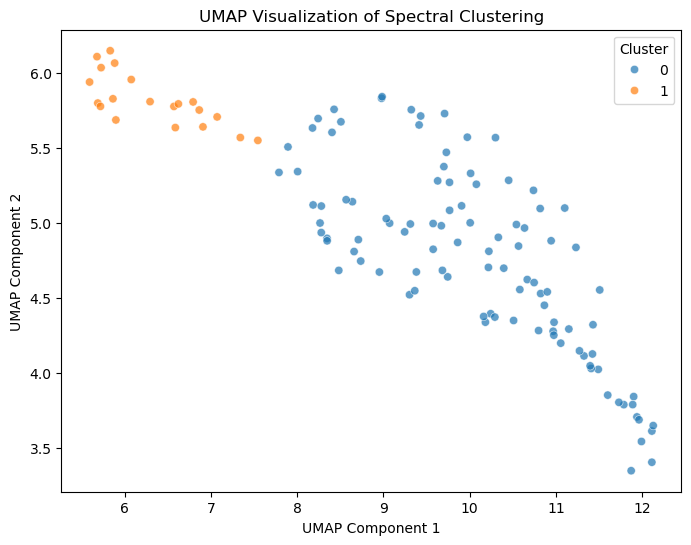

Clustered data saved to C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\/data_cell_for_spectralclustering.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from umap import UMAP

# Load CSV file
file_path = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"
df = pd.read_csv(file_path)

# Drop unique identifier column (assuming 'Cell Number' is the unique identifier)
df = df.drop(columns=['Cell Number'], errors='ignore')

# Standardize features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Apply PCA (adjust to max available features)
n_components = min(9, df_scaled.shape[1])  # Ensuring it doesn't exceed feature count
pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(df_scaled)

# Determine optimal cluster count (ensure valid value)
n_clusters = max(2, min(6, len(df) // 500))  # Minimum of 2 clusters

# Apply Spectral Clustering with nearest neighbor affinity
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42)
labels = spectral.fit_predict(df_pca)

# Compute Silhouette Score
sil_score = silhouette_score(df_pca, labels)
print(f'Silhouette Score: {sil_score:.4f}')

# Apply UMAP for visualization
umap = UMAP(n_components=5, random_state=42)
df_umap = umap.fit_transform(df_pca)

# Plot UMAP results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_umap[:, 0], y=df_umap[:, 1], hue=labels, palette='tab10', alpha=0.7)
plt.title('UMAP Visualization of Spectral Clustering')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster')
plt.show()

# Save clustered data
output_path = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\/data_cell_for_spectralclustering.csv"
df.to_csv(output_path, index=False)
print(f"Clustered data saved to {output_path}")






Completed clustering for n=2 with Silhouette Score: 0.4411 and JS Distance: 0.0029


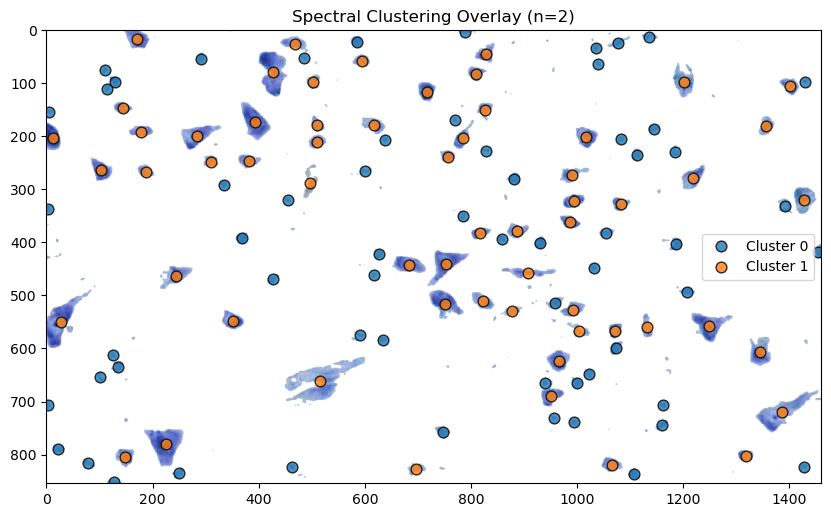

Completed clustering for n=3 with Silhouette Score: 0.3568 and JS Distance: 0.0646


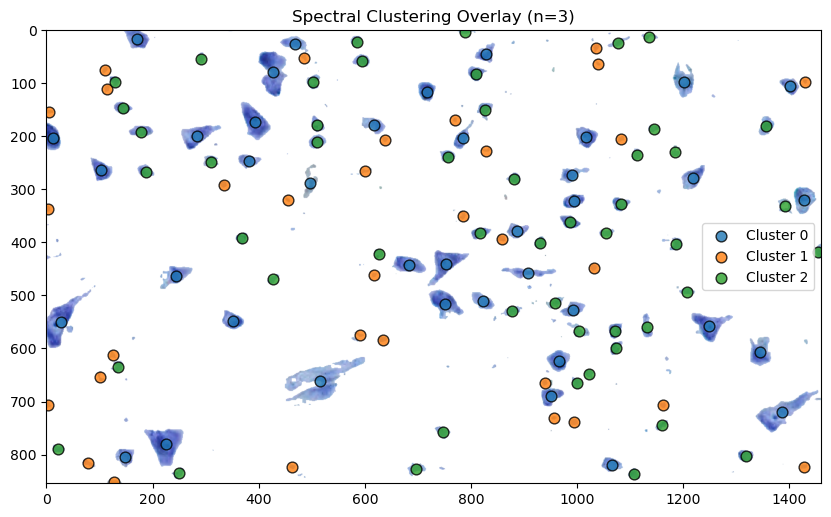

Completed clustering for n=4 with Silhouette Score: 0.4563 and JS Distance: 0.0421


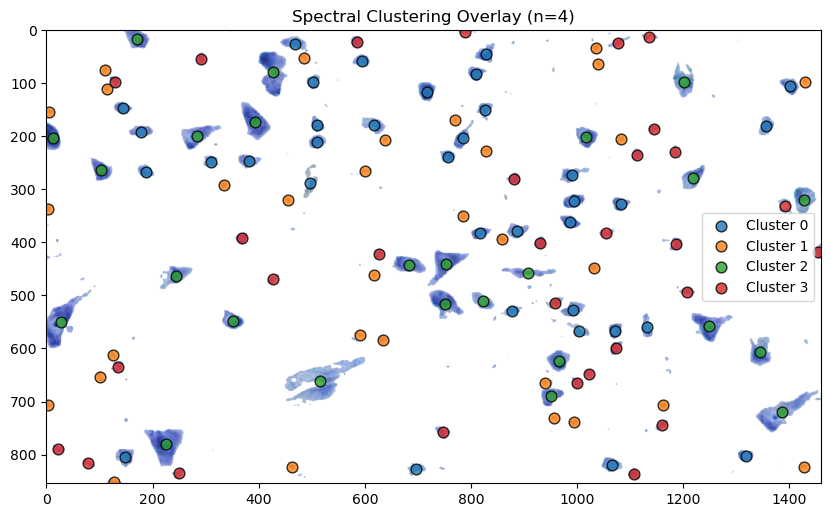

Completed clustering for n=5 with Silhouette Score: 0.4950 and JS Distance: 0.0568


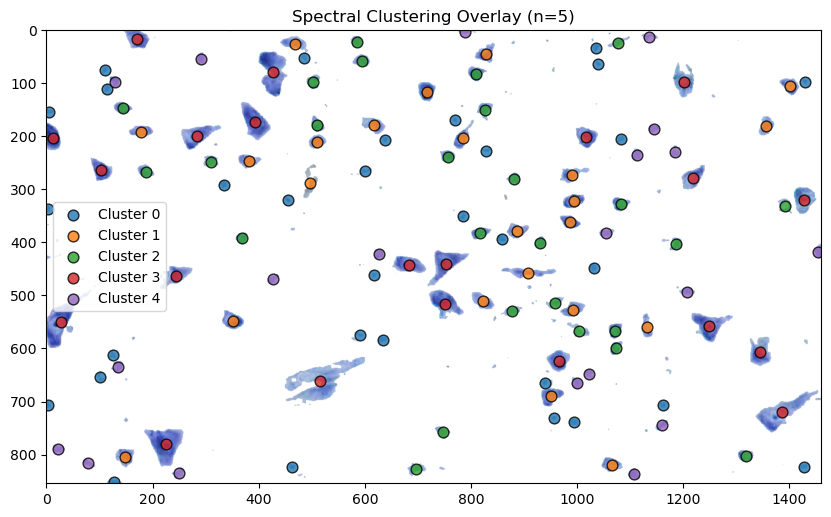

Completed clustering for n=6 with Silhouette Score: 0.5013 and JS Distance: 0.1035


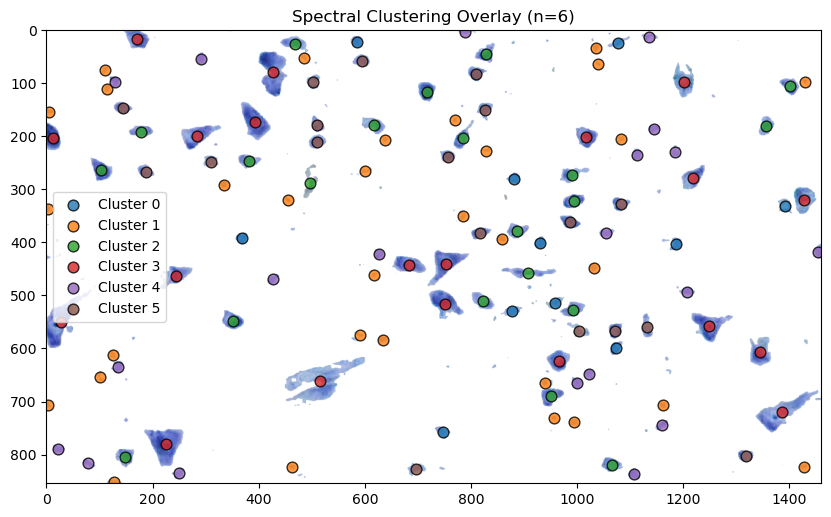

Completed clustering for n=7 with Silhouette Score: 0.4235 and JS Distance: 0.0816


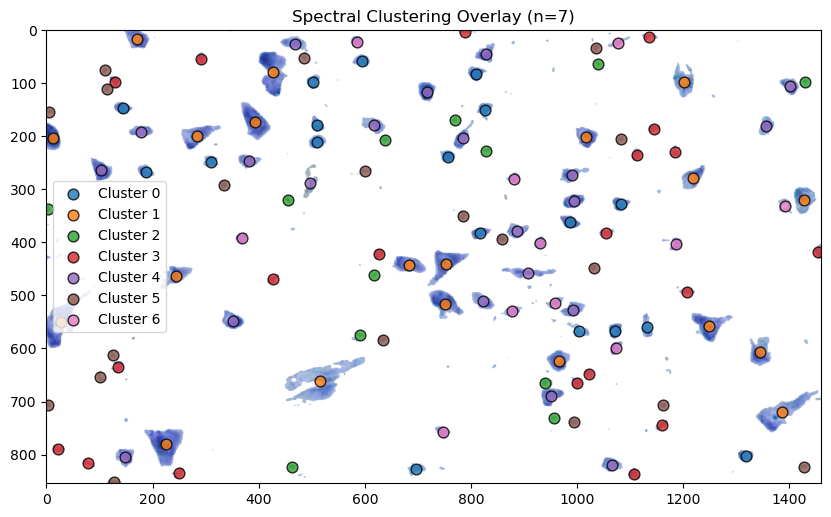

Completed clustering for n=8 with Silhouette Score: 0.4200 and JS Distance: 0.0692


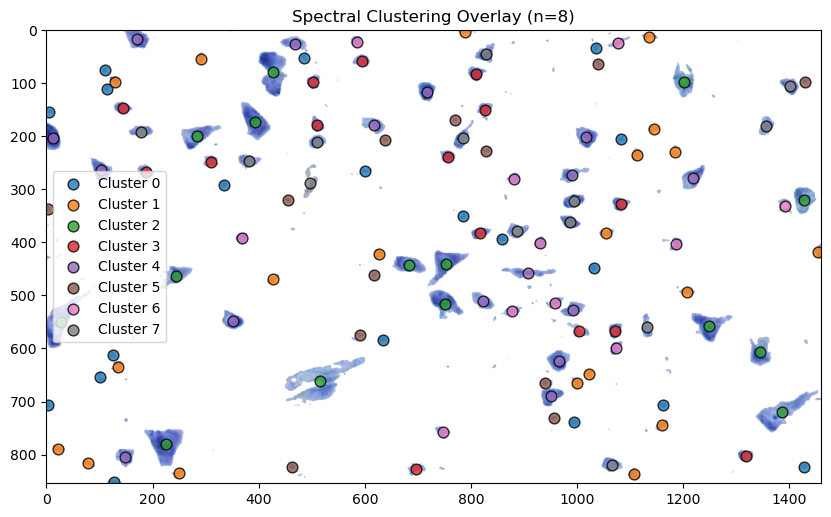

Completed clustering for n=9 with Silhouette Score: 0.4162 and JS Distance: 0.0938


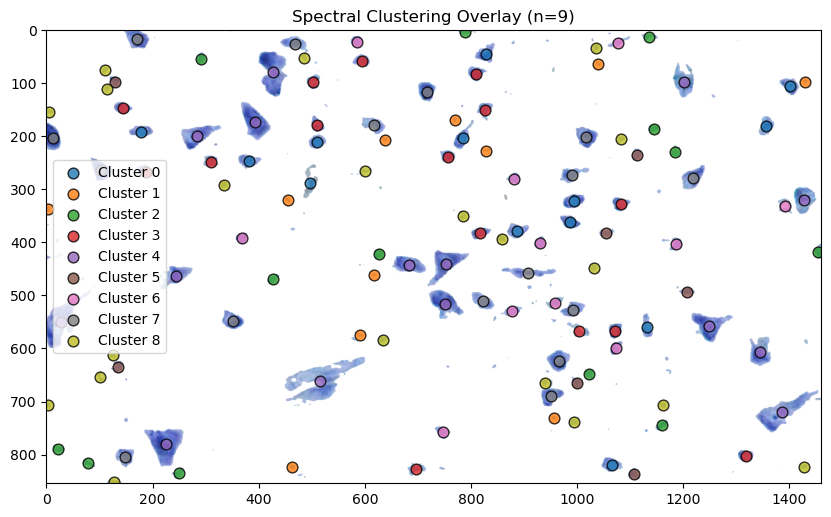

Completed clustering for n=10 with Silhouette Score: 0.4458 and JS Distance: 0.0865


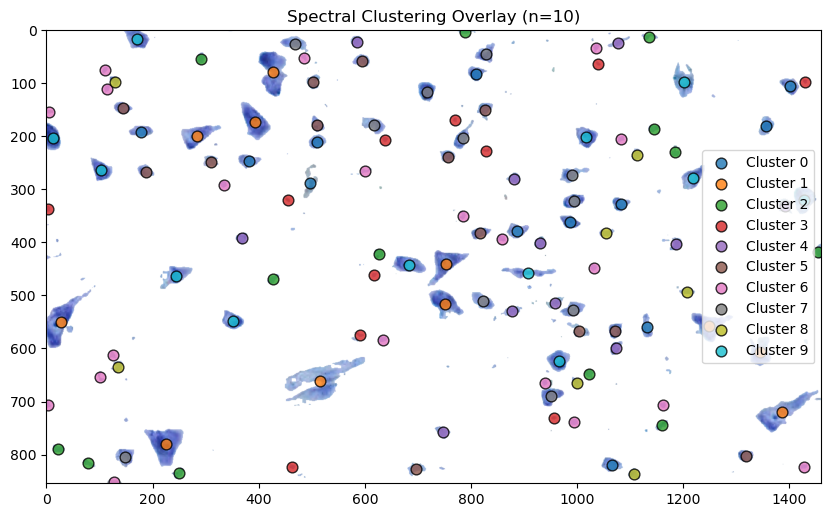

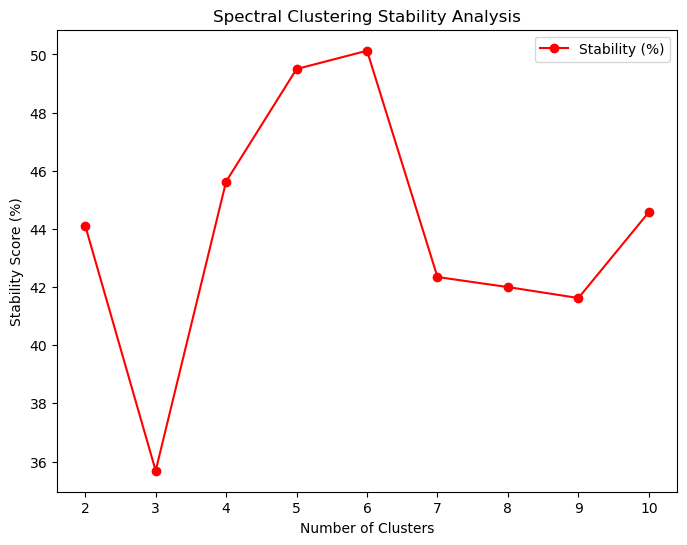

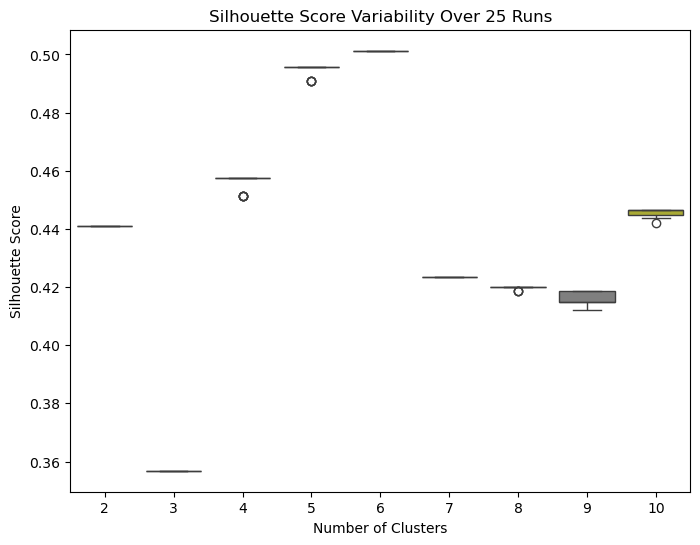

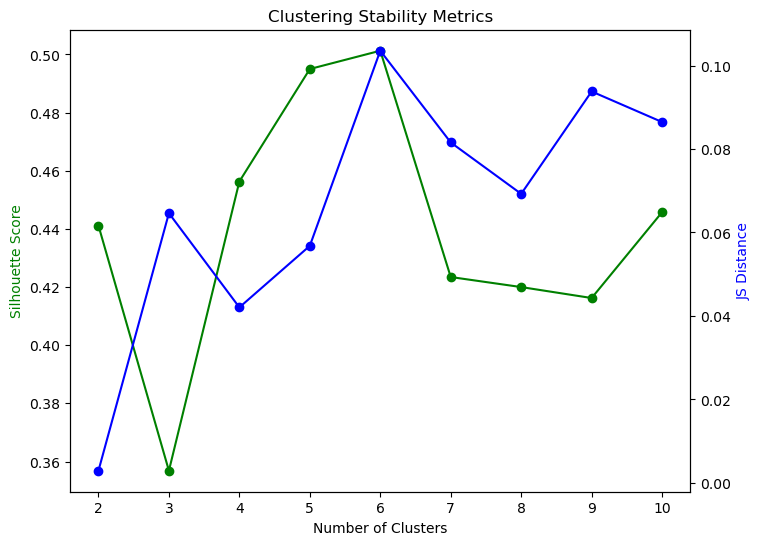

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
import cv2

# Load Data
feature_csv_path =  r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"
coordinate_csv_path = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\moved_files\data_cell_with_centroids.csv"
image_path = "restored_white_background_debug-Copy1.png"

df_features = pd.read_csv(feature_csv_path)
df_coordinates = pd.read_csv(coordinate_csv_path)

df = df_coordinates.merge(df_features, on="Cell Number")

# Apply feature weights
weights = {"Solidity": 3, "Circularity": 3, "Local Homogeneity": 3, "Aspect Ratio": 3}
for feature, weight in weights.items():
    if feature in df_features.columns:
        df_features[feature] *= weight

X = df_features.drop(columns=["Cell Number"])

# Set cluster range
n_clusters_range = range(2, 11)
silhouette_scores = []
js_distances = []
stability_scores = []
silhouette_runs_all = {n: [] for n in n_clusters_range}

# Load Image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_height, img_width, _ = image.shape

for n_clusters in n_clusters_range:
    silhouette_runs = []
    for _ in range(25):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=None)
        cluster_labels = model.fit_predict(X)
        silhouette_runs.append(silhouette_score(X, cluster_labels))
    
    mean_silhouette = np.mean(silhouette_runs)
    silhouette_scores.append(mean_silhouette)
    stability_scores.append(mean_silhouette * 100)
    silhouette_runs_all[n_clusters] = silhouette_runs  # Store all silhouette runs

    js_distance = jensenshannon(np.bincount(cluster_labels, minlength=n_clusters), np.ones(n_clusters) / n_clusters)
    js_distances.append(js_distance)
    
    print(f"Completed clustering for n={n_clusters} with Silhouette Score: {mean_silhouette:.4f} and JS Distance: {js_distance:.4f}")
    
    # Plot overlay
    plt.figure(figsize=(10, 10))
    plt.imshow(image, extent=[0, img_width, img_height, 0])
    
    unique_clusters = np.unique(cluster_labels)
    colors = sns.color_palette("tab10", len(unique_clusters))
    
    for cluster, color in zip(unique_clusters, colors):
        cluster_points = df[cluster_labels == cluster]
        plt.scatter(cluster_points["X Centroid"], cluster_points["Y Centroid"], color=color, label=f"Cluster {cluster}", edgecolors='k', s=60, alpha=0.8)
    
    plt.legend()
    plt.xlim(0, img_width)
    plt.ylim(img_height, 0)
    plt.title(f"Spectral Clustering Overlay (n={n_clusters})")
    plt.savefig(f"spectral_cluster_n{n_clusters}.png")
    plt.show()

# Plot Stability Percentage
plt.figure(figsize=(8, 6))
plt.plot(n_clusters_range, stability_scores, 'ro-', label="Stability (%)")
plt.xlabel("Number of Clusters")
plt.ylabel("Stability Score (%)")
plt.title("Spectral Clustering Stability Analysis")
plt.legend()
plt.show()

# Silhouette Score Box Plot (Corrected)
plt.figure(figsize=(8, 6))
sns.boxplot(data=[silhouette_runs_all[n] for n in n_clusters_range])
plt.xticks(ticks=range(len(n_clusters_range)), labels=n_clusters_range)  # Correct x-axis labels
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Variability Over 25 Runs")
plt.show()

# Silhouette and JS Distance Scores
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()
ax1.plot(n_clusters_range, silhouette_scores, 'go-', label="Silhouette Score")
ax2.plot(n_clusters_range, js_distances, 'bo-', label="JS Distance")
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Silhouette Score", color='g')
ax2.set_ylabel("JS Distance", color='b')
plt.title("Clustering Stability Metrics")
plt.show()
